In [ ]:
from os import system

import geopandas as gpd
import pystac_client
from contextily import add_basemap

In [36]:
# Dates parameter to generate
before = "2025-01"
after = "2025-02/2025-03"
dates_list = [before, after]

,grid_id,min_x,max_x,min_y,max_y,x_id,y_id,geometry
0,01Y_01X,106.339279,106.839279,-6.788518,-6.288518,1,1,"POLYGON ((106.84928 -6.79852, 106.84928 -6.278..."
0,02Y_01X,106.339279,106.839279,-6.288518,-5.788518,1,2,"POLYGON ((106.84928 -6.29852, 106.84928 -5.778..."
0,01Y_02X,106.839279,107.339279,-6.788518,-6.288518,2,1,"POLYGON ((107.34928 -6.79852, 107.34928 -6.278..."
0,02Y_02X,106.839279,107.339279,-6.288518,-5.788518,2,2,"POLYGON ((107.34928 -6.29852, 107.34928 -5.778..."


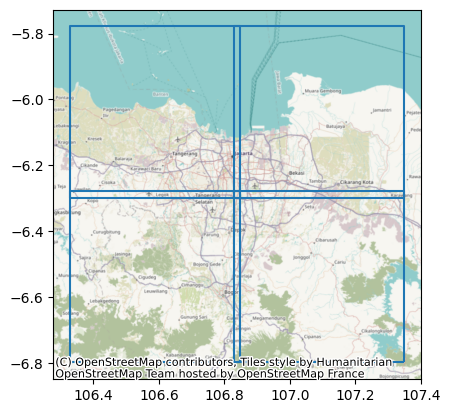

In [4]:
# ROI
roi = gpd.read_parquet(
    "gs://gee-ramiqcom-bucket/flood_map/roi/jabodetabek_grids.parquet"
)
ax = roi.boundary.plot()
add_basemap(ax=ax, crs="EPSG:4326")
roi

In [21]:
# Collection names
collections = [
    dict(name="sentinel-1-rtc", bands=["vv", "vh"], scaling=1e4),
    dict(
        name="sentinel-2-l2a",
        bands=["B02", "B03", "B04", "B08", "B11", "B12"],
        scaling=1,
    ),
]

In [37]:
# Run per dates and per grids
for x in range(1, len(dates_list)):
    d = dates_list[x]
    print(f"Processing date {d} ({x + 1} / {len(dates_list)})")

    for y in range(len(roi)):
        grid = roi.iloc[y : y + 1]
        grid_id = grid.iloc[0]["grid_id"]

        print(f"Processing grid {grid_id} ({y + 1} / {len(roi)})")

        polygon = grid.iloc[0].geometry
        bounds = tuple(grid.total_bounds)

        # Create a shape
        width = int(abs(bounds[0] - bounds[2]) * 111_000 / 10)
        height = int(abs(bounds[1] - bounds[3]) * 111_000 / 10)
        shape = (height, width)

        # Search for planetary computer for Sentinel-1 and Sentinel-2
        for z in range(1):
            collection = collections[z]
            col_name = collection["name"]

            print(f"Processing collection {col_name} ({z + 1} / {len(collections)})")

            bands = collection["bands"]
            scaling = collection["scaling"]

            # STAC API client
            client = pystac_client.Client.open(
                "https://planetarycomputer.microsoft.com/api/stac/v1"
            )

            # Collection
            col = client.search(
                collections=[col_name], bbox=bounds, datetime=d
            ).item_collection()

            # Get date list
            dates = list(
                set([item.properties["datetime"].split("T")[0] for item in col])
            )

            # bands images list
            bands_images = []

            # Run per item and bands
            for b in range(len(bands)):
                band = bands[b]

                print(f"Processing band {band} ({b + 1} / {len(bands)})")

                date_images = []

                # Run per dates inside the collection
                for date_item in dates:
                    # Collection
                    col = client.search(
                        collections=[col_name], bbox=bounds, datetime=date_item
                    ).item_collection()

                    # Item id
                    item_id = f"{date_item}_{grid_id}_{band}"
                    image_list = f"{item_id}.txt"

                    # Create a text contain all images path
                    with open(image_list, "w") as file:
                        file.write(
                            "\n".join(
                                [
                                    f"/vsicurl?pc_url_signing=yes&pc_collection={col_name}&url={item.assets[band].href}"
                                    for item in col
                                ]
                            )
                        )

                    # Create VRT
                    vrt = f"{item_id}.vrt"
                    system(f"""
                        gdalbuildvrt \
                            -r bilinear \
                            -input_file_list {image_list} \
                            -overwrite \
                            {vrt}
                    """)

                    system(f"del {image_list}")

                    # Create an actual image
                    image = f"{item_id}.tif"
                    system(f"""
                        gdalwarp \
                            -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} \
                            -t_srs EPSG:4326 \
                            -ts {shape[1]} {shape[0]} \
                            -of COG \
                            -co COMPRESS=ZSTD \
                            -ot Float32 \
                            -dstnodata NaN \
                            -r bilinear \
                            -overwrite \
                            {vrt} \
                            {image}
                    """)

                    system(f"del {vrt}")

                    # Put the collection name into a list
                    date_images.append(image)

                # Do median composite
                median_band = f"median_{band}.tif"
                system(f"""
                    gdal_calc \
                       -A {" ".join(date_images)} \
                       --outfile={median_band} \
                       --NoDataValue=0 \
                       --overwrite \
                       --calc=nanmedian(A*{scaling},axis=0)
                """)

                system(f"del {' '.join(date_images)}")

                bands_images.append(median_band)

            # Create a list of bands images
            bands_image_list = "bands.txt"
            with open(bands_image_list, "w") as file:
                file.write("\n".join(bands_images))

            # Image id
            image_id = f"{col_name}_{grid_id}_{d.replace('/', '_')}"

            # Create VRT that contain all bands
            vrt_band = f"{image_id}.vrt"
            system(f"""
                gdalbuildvrt \
                   -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} \
                   -input_file_list {bands_image_list} \
                   -r bilinear \
                   -overwrite \
                   -separate \
                   {vrt_band}
            """)

            system(f"del {bands_image_list}")

            # Final image
            print(f"Creating COG {col_name} {d}")
            final_image = f"{image_id}.tif"
            system(f"""
                gdalwarp \
                    -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} \
                    -t_srs EPSG:4326 \
                    -ts {shape[1]} {shape[0]} \
                    -ot UInt16 \
                    -of COG \
                    -co COMPRESS=ZSTD \
                    -dstnodata 0 \
                    -r bilinear \
                    -overwrite \
                    {vrt_band} \
                    {final_image}
            """)

            system(f"del {bands_image_list} {' '.join(bands_images)}")
            system(f"del {vrt_band}")

            # Upload it to cloud storage
            print(f"Uploading COG {image_id}")
            cloud_path = f"gs://gee-ramiqcom-bucket/flood_map/{col_name}/{image_id}.tif"
            system(f"gcloud storage cp {final_image} {cloud_path}")

Processing date 2025-02/2025-03 (2 / 2)
Processing grid 01Y_01X (1 / 4)
Processing collection sentinel-1-rtc (1 / 2)
Processing band vv (1 / 2)
Processing band vh (2 / 2)
Creating COG sentinel-1-rtc 2025-02/2025-03
Uploading COG sentinel-1-rtc_01Y_01X_2025-02_2025-03
Processing grid 02Y_01X (2 / 4)
Processing collection sentinel-1-rtc (1 / 2)
Processing band vv (1 / 2)
Processing band vh (2 / 2)
Creating COG sentinel-1-rtc 2025-02/2025-03
Uploading COG sentinel-1-rtc_02Y_01X_2025-02_2025-03
Processing grid 01Y_02X (3 / 4)
Processing collection sentinel-1-rtc (1 / 2)
Processing band vv (1 / 2)
Processing band vh (2 / 2)
Creating COG sentinel-1-rtc 2025-02/2025-03
Uploading COG sentinel-1-rtc_01Y_02X_2025-02_2025-03
Processing grid 02Y_02X (4 / 4)
Processing collection sentinel-1-rtc (1 / 2)
Processing band vv (1 / 2)
Processing band vh (2 / 2)
Creating COG sentinel-1-rtc 2025-02/2025-03
Uploading COG sentinel-1-rtc_02Y_02X_2025-02_2025-03
